# Algorytm Grovera

Opis

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from copy import deepcopy

In [ ]:
def create_nice_bar_plot(data_dict):
    
    categories = data_dict.keys()
    valuesdict = None
    valuesdict = data_dict.copy()
    values = [ v for v in valuesdict.values() ]
    for index,value in enumerate(values):
        values[index] = round(value, 4)
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(categories, values, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Possible states', fontsize=12, fontweight='bold')
    ax.set_ylabel('State coordinates', fontsize=12, fontweight='bold')
    ax.set_title('Algorithm Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim(0, max(values))
    
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height / 5,
                f'{value}%', ha='center', va='bottom', fontweight='bold')
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    plt.xticks(rotation=45, ha='right')    
    plt.tight_layout()
    
    return fig, ax

In [130]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer.primitives import Sampler

n = 2
cr = ClassicalRegister(n)
qr = QuantumRegister(n)
qc = QuantumCircuit(qr, cr)

for qubit in qr:
    qc.h(qubit)

for i in range(n):
    qc.measure(qr[i], cr[i])

sampler = Sampler()
job     = sampler.run(qc)
result  = job.result()
quasi   = result.quasi_dists[0]

print("Quasi‑probability distribution:")
print(quasi)

Quasi‑probability distribution:
{0: 0.2626953125, 2: 0.234375, 1: 0.2705078125, 3: 0.232421875}


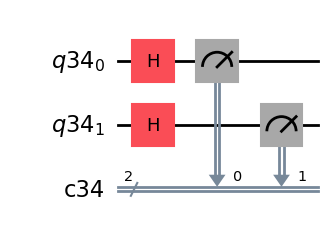

In [131]:
qc.draw("mpl")

In [132]:
class GroverAlgorithm:
    """
    Implementation of Grover's Algorithm for quantum database search
    """
    
    def __init__(self, marked_items, num_qubits):
        """
        Initialize Grover's algorithm
        
        Args:
            marked_items: List of items to search for (binary strings)
            num_qubits: Number of qubits needed
        """
        self.marked_items = marked_items
        self.num_qubits = num_qubits
        self.num_items = 2 ** num_qubits
        
    def create_oracle(self):
        """
        Step 1: Create the oracle that marks the target items
        The oracle flips the phase of the marked items
        """
        oracle = QuantumCircuit(self.num_qubits, name='Oracle')
        
        for marked_item in self.marked_items:
            # Convert binary string to integer
            if isinstance(marked_item, str):
                marked_value = int(marked_item, 2)
            else:
                marked_value = marked_item
            
            # Create the oracle for this specific marked item
            # Flip bits where the marked item has 0s
            for qubit in range(self.num_qubits):
                if not (marked_value >> qubit) & 1:
                    oracle.x(qubit)
            
            # Multi-controlled Z gate (phase flip)
            if self.num_qubits == 1:
                oracle.z(0)
            elif self.num_qubits == 2:
                oracle.cz(0, 1)
            else:
                # For more qubits, use multi-controlled Z
                oracle.h(self.num_qubits - 1)
                oracle.mcx(list(range(self.num_qubits - 1)), self.num_qubits - 1)
                oracle.h(self.num_qubits - 1)
            
            # Flip bits back
            for qubit in range(self.num_qubits):
                if not (marked_value >> qubit) & 1:
                    oracle.x(qubit)
        
        return oracle
    
    def create_diffuser(self):
        """
        Step 2: Create the diffusion operator (amplitude amplification)
        This performs inversion about average
        """
        diffuser = QuantumCircuit(self.num_qubits, name='Diffuser')
        
        # Apply H gates
        diffuser.h(range(self.num_qubits))
        
        # Apply X gates
        diffuser.x(range(self.num_qubits))
        
        # Multi-controlled Z gate
        if self.num_qubits == 1:
            diffuser.z(0)
        elif self.num_qubits == 2:
            diffuser.cz(0, 1)
        else:
            diffuser.h(self.num_qubits - 1)
            diffuser.mcx(list(range(self.num_qubits - 1)), self.num_qubits - 1)
            diffuser.h(self.num_qubits - 1)
        
        # Apply X gates
        diffuser.x(range(self.num_qubits))
        
        # Apply H gates
        diffuser.h(range(self.num_qubits))
        
        return diffuser
    
    def calculate_iterations(self):
        """
        Step 3: Calculate optimal number of iterations
        For M marked items out of N total items: π/4 * √(N/M)
        """
        M = len(self.marked_items)  # Number of marked items
        N = self.num_items  # Total number of items
        
        optimal_iterations = int(np.pi / 4 * np.sqrt(N / M))
        return optimal_iterations
    
    def create_grover_circuit(self):
        """
        Step 4: Create the complete Grover circuit
        """
        # Create quantum and classical registers
        qreg = QuantumRegister(self.num_qubits)
        creg = ClassicalRegister(self.num_qubits)
        circuit = QuantumCircuit(qreg, creg)
        
        # Step 1: Initialize superposition (equal amplitude for all states)
        circuit.h(qreg)
        circuit.barrier()
        
        # Step 2: Apply Grover iterations
        oracle = self.create_oracle()
        diffuser = self.create_diffuser()
        iterations = self.calculate_iterations()
        
        print(f"Applying {iterations} Grover iterations...")
        
        for i in range(iterations):
            # Apply oracle
            circuit.compose(oracle, qreg, inplace=True)
            circuit.barrier()
            
            # Apply diffuser
            circuit.compose(diffuser, qreg, inplace=True)
            circuit.barrier()
        
        # Step 3: Measure
        circuit.measure(qreg, creg)
        
        return circuit
    
    def run_simulation(self, shots=1024):
        """
        Step 5: Run the algorithm and analyze results
        """
        circuit = self.create_grover_circuit()
        
        # Use Aer simulator
        simulator = AerSimulator()
        
        # Transpile circuit for the simulator
        pm = generate_preset_pass_manager(backend=simulator, optimization_level=1)
        transpiled_circuit = pm.run(circuit)
        
        # Run the simulation
        job = simulator.run(transpiled_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts()
        
        return circuit, counts

def demonstrate_grover():
    """
    Demonstrate Grover's algorithm with a concrete example
    """
    print("=== GROVER'S ALGORITHM DEMONSTRATION ===\n")
    
    # Example: Search for items '10' and '11' in a 2-qubit system
    marked_items = ['10']  # Binary strings
    num_qubits = 2
    
    print(f"Searching for items: {marked_items}")
    print(f"Number of qubits: {num_qubits}")
    print(f"Total search space: {2**num_qubits} items")
    
    # Create Grover instance
    grover = GroverAlgorithm(marked_items, num_qubits)
    
    # Run the algorithm
    circuit, counts = grover.run_simulation(shots=1024)
    
    print(f"\nResults after {grover.calculate_iterations()} iterations:")
    print("Measurement counts:", counts)
    
    # Calculate success probability
    total_shots = sum(counts.values())
    success_count = sum(counts.get(item, 0) for item in marked_items)
    success_probability = success_count / total_shots
    
    print(f"Success probability: {success_probability:.3f}")
    print(f"Expected theoretical success probability: ~{1.0:.3f}")
    
    return circuit, counts


Creating nice bar plot...


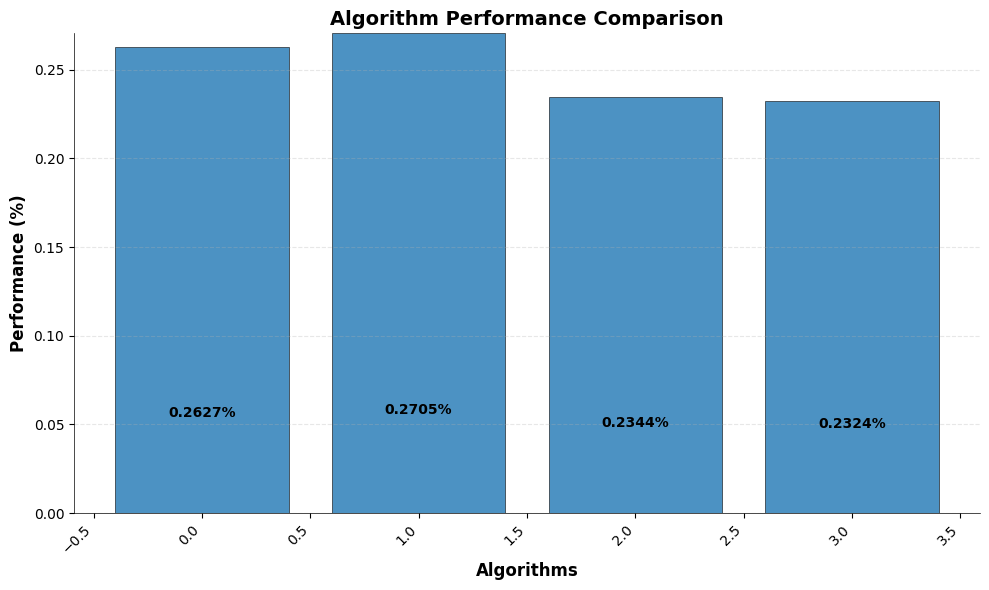


=== GROVER'S ALGORITHM DEMONSTRATION ===

Searching for items: ['10']
Number of qubits: 2
Total search space: 4 items
Applying 1 Grover iterations...

Results after 1 iterations:
Measurement counts: {'10': 1024}
Success probability: 1.000
Expected theoretical success probability: ~1.000

Creating visualization...

Grover Circuit:


In [133]:
if __name__ == "__main__":
    # Create nice bar plot
    print("Creating nice bar plot...")
    fig, ax = create_nice_bar_plot(quasi)
    plt.show()
    
    print("\n" + "="*50)
    
    # Demonstrate Grover's algorithm
    circuit, counts = demonstrate_grover()
    
    # Visualize results
    print("\nCreating visualization...")
    plot_histogram(counts, title="Grover's Algorithm Results")
    plt.show()
    
    # Print circuit
    print("\nGrover Circuit:")


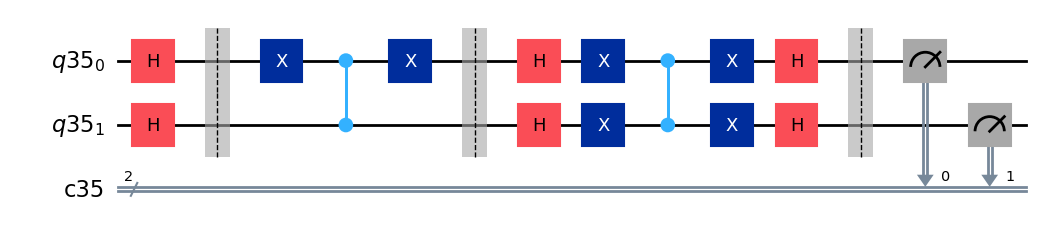

: 

In [ ]:
circuit.draw("mpl")